# Import library

In [ ]:
!pip install optuna
!pip install japanize_matplotlib
!pip install tensorflow-determinism
!pip install jpholiday
!pip install pandas_profiling
!pip install torch
!pip install pandarallel
!pip install pyheif
!pip install timm
!pip install huggingface_hub
!pip install torch
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=556279bb263653eb72c20b4d7b38beda4821edc70aef1d27327bf986cb382ae9
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.8/395.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 10

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras.backend as K
import seaborn as sns
import sys
import re
import os
import optuna
import keras
import cv2
import japanize_matplotlib
import torch
import warnings
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from torchmetrics.classification import MulticlassAccuracy
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV
# from keras.preprocessing.image import ImageDataGenerator, array_to_img
# , img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import VGG16
from sklearn.metrics import f1_score, cohen_kappa_score
from keras.utils import to_categorical

In [ ]:
# tensorflow version
print('tensorflow version:', tf.__version__)
print('keras version:', keras.__version__)
print('torch version:', torch.__version__)
# setting reproducibility of tensorflow
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tensorflow version: 2.14.0
keras version: 2.14.0
torch version: 2.1.0+cu118


# Util

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    # Set the seed for the global random number generator
    tf.random.set_seed(seed)

    # If using GPU, set the seed for GPU operations
    if tf.test.is_gpu_available():
        # Make GPU operations deterministic
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
        os.environ['TF_CUDNN_USE_AUTOTUNE'] = '0'

        # Set a seed for GPU
        # If using GPU, set the mixed precision policy
        if tf.config.list_physical_devices('GPU'):
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)

    return seed

# Config

In [ ]:
# Fix seed value
seed = seed_everything()
print('seed:', seed)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


seed: 42


In [ ]:
# Display all columns * Do not use this due to the capacity of memory unless it is essential
pd.set_option('display.max_rows', None)

In [ ]:
# Settings
# Undisplay warnings
warnings.filterwarnings('ignore')

# pandas parallelization
# pandarallel.initialize(progress_bar=False)

# pandas display config
pd.options.display.max_rows = 100
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 100

# Display precision of floating point in numpy
np.set_printoptions(suppress=True, precision=4)

# Display precision of floating point in pandas
pd.options.display.float_format = '{:.2f}'.format

# default of font size
plt.rcParams["font.size"] = 20

# graph font size
g_fsize = 16

# matplotlib / seaborn for displaying Japanese
sns.set(font='IPAexGothic')

In [ ]:
# # Setting path and data file
# image_path = 'dataset/'

# Setting path and data file
data_path = '/content/drive/MyDrive/Data_Analysis/data/'
sys.path.append(data_path)
image_path = data_path + 'Shimokita/Streetview/dataset/'

train_dataset_file = 'train_dataset_for_vit.npz'
gsv_dataset_file = 'gsv_dataset_for_vit.npz'
local_dataset_file = 'local_dataset_for_vit.npz'

# Read image data set * start from here
* dataset shape -> (image, heght, weight, RGB)
* Ref）https://tomomai.com/python-dataset/

## learning dataset

In [ ]:
photos = np.load(image_path + train_dataset_file)
#画像データ
x_org = photos['x']
#ラベルデータ
y_org = photos['y']

print(x_org.shape)
print(y_org.shape)
print(y_org)

(1220, 224, 224, 3)
(1220,)
[0 0 0 ... 3 3 3]


In [ ]:
#ラベルを文字列に変換する関数
def transform_label_to_literal(y):
  y_df = pd.DataFrame(y)
  y_label_df = y_df[0].map({0:'cloting area',1:'restaurant area',2:'redevelopment area',3:'residential area'})
  return y_label_df

In [ ]:
#下北沢データセットの正解クラス文字列
y_label_df = transform_label_to_literal(y_org)
y_label_df

0           cloting area
1           cloting area
2           cloting area
3           cloting area
4           cloting area
              ...       
1215    residential area
1216    residential area
1217    residential area
1218    residential area
1219    residential area
Name: 0, Length: 1220, dtype: object

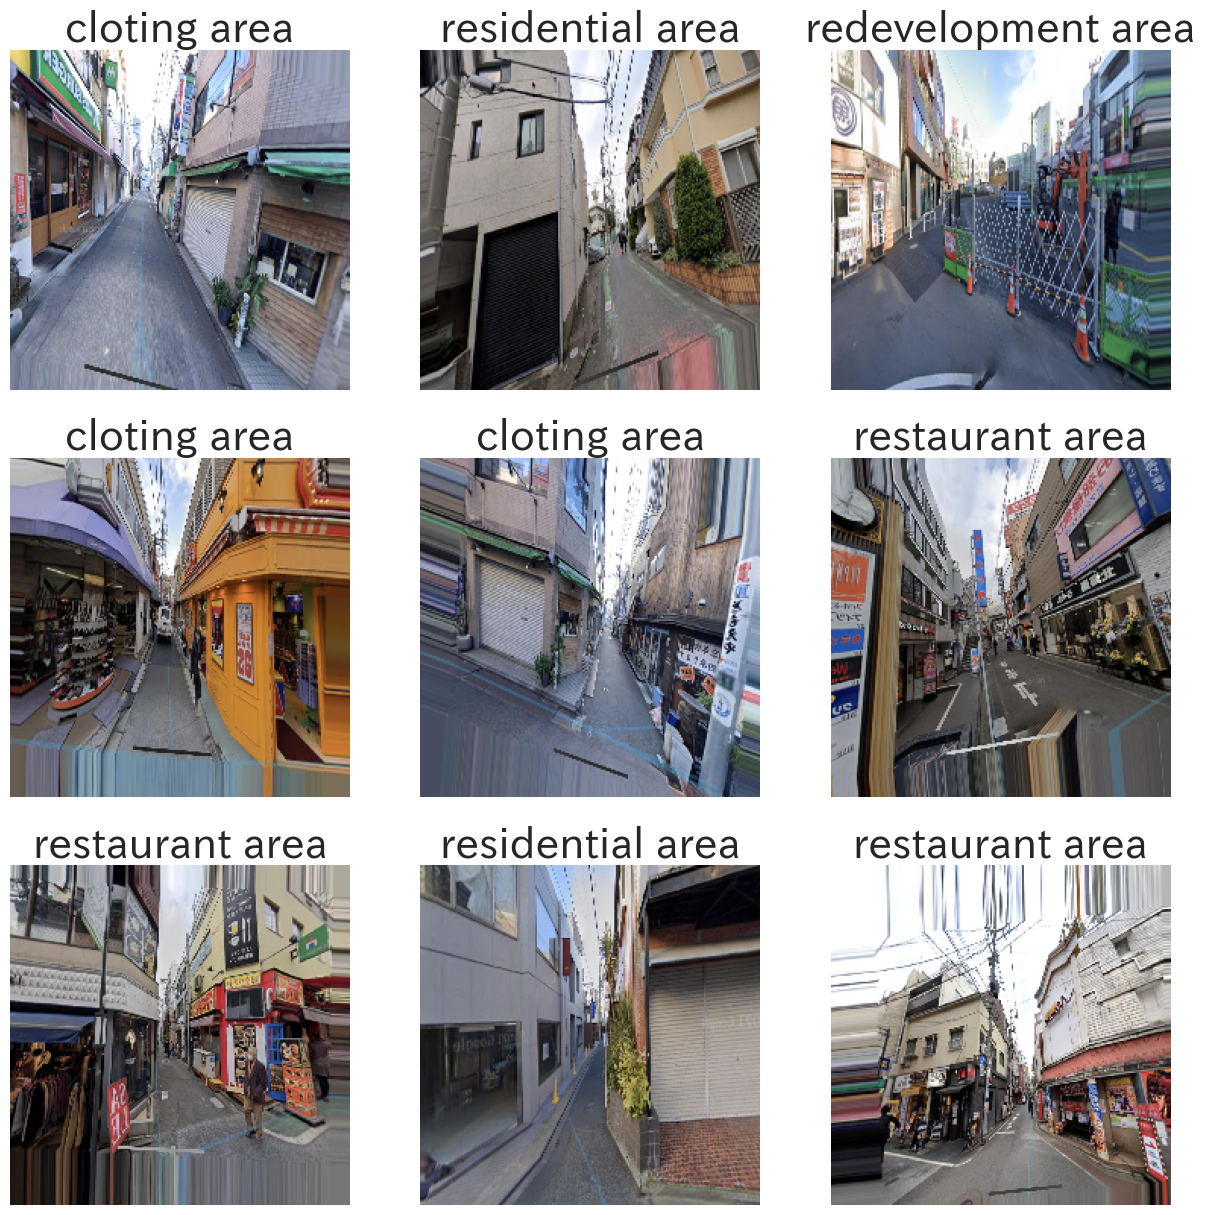

In [ ]:
#学習用データの画像表示
img_n =9

idx=0

plt.figure(figsize=(15,15))
for i in range(img_n):
  plt.subplot(3,3,i+1)
  plt.axis('off')

  for j in range(img_n):
    r = random.randint(0,1200)
    img = ((x_org[j+r]).astype(np.uint8))
    plt.imshow(img)
    plt.title('{}'.format(y_label_df[j+r]),fontsize=30)
plt.show()

Kearsでデータを正規化する
参照：https://hatakazu.hatenablog.com/entry/2017/06/08/045953

In [ ]:
# 画素値を0から1の範囲に正規化（（⇒学習の時に計算量を減らす為。結果を出力する時に、再び255掛ける。）
X = x_org / 255.0
print(X.shape)

# クラスの形式を変換
# ラベルから多次元のベクトルに（各データごとに正解のラベルが1，不正解が0の1次元のベクトル）
Y = to_categorical(y_org, 4)
print(Y.shape)
print(Y)

(1220, 224, 224, 3)
(1220, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


## test data①(Google Street View)


In [ ]:
photos_test1 = np.load(image_path + gsv_dataset_file)
#画像データ
x_test1_org = photos_test1['x']
#ラベルデータ
y_test1_org = photos_test1['y']

print(x_test1_org.shape)
print(y_test1_org.shape)

(61, 224, 224, 3)
(61,)


In [ ]:
#GSVデータセットの正解クラス文字列
y_label_df1 = transform_label_to_literal(y_test1_org)

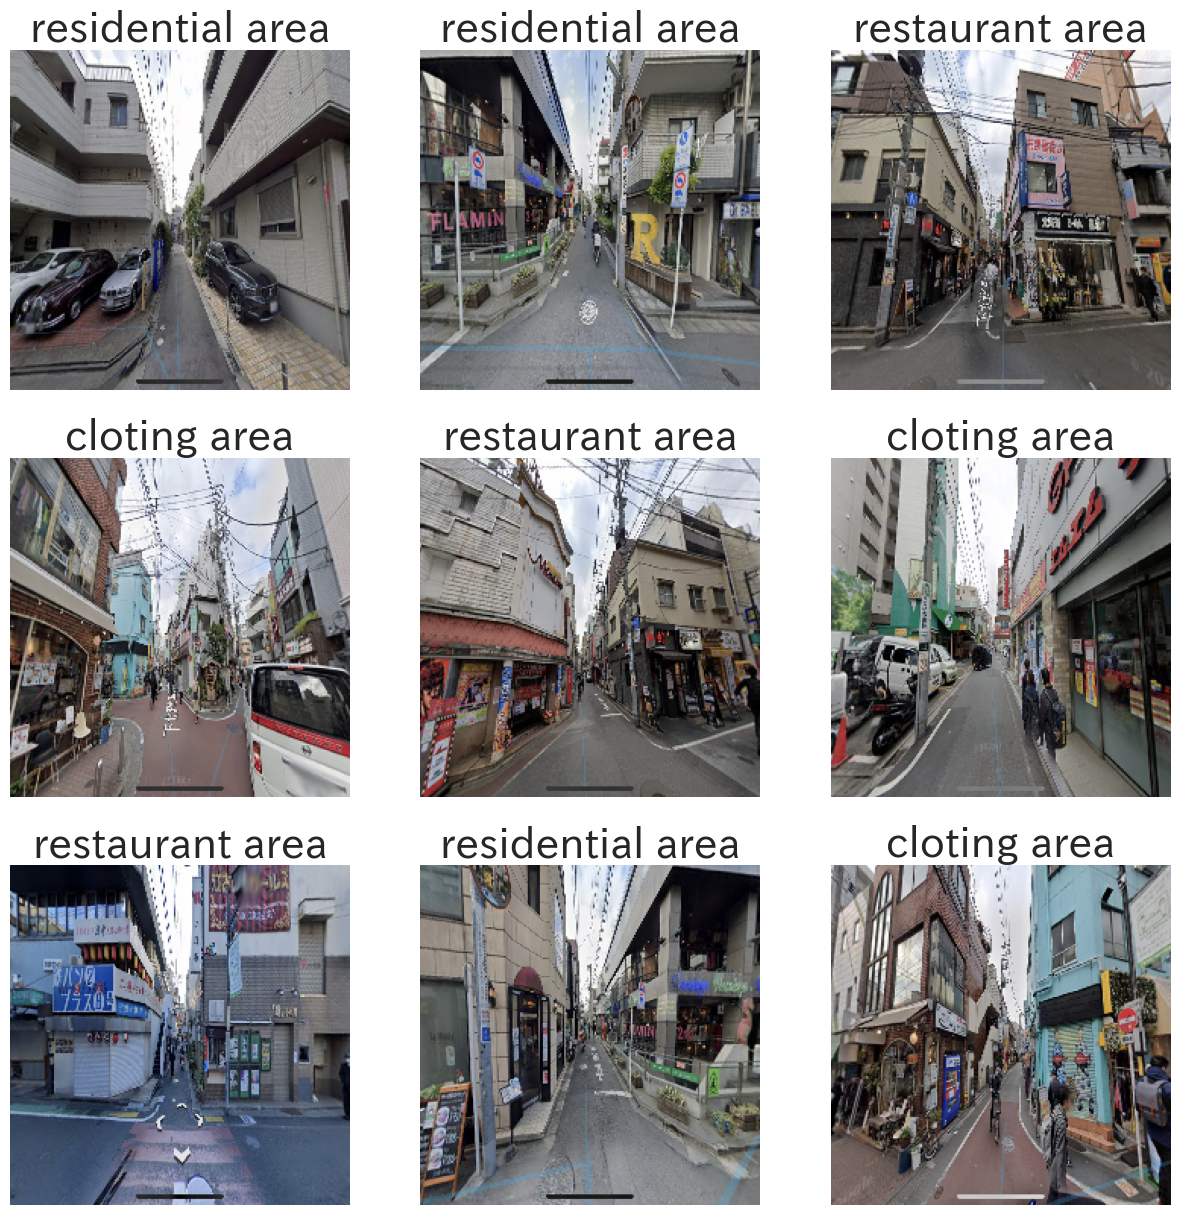

In [ ]:
#GSVデータセットの画像表示
img_n =9

idx=0

plt.figure(figsize=(15,15))
for i in range(img_n):
  plt.subplot(3,3,i+1)
  plt.axis('off')

  for j in range(img_n):
    r = random.randint(0,50)
    img = ((x_test1_org[j+r]).astype(np.uint8))
    plt.imshow(img)
    plt.title(y_label_df1[j+r],fontsize=30)
plt.show()

In [ ]:
# 画素値を0から1の範囲に変換（（⇒学習の時に計算量を減らす為。結果を出力する時に、再び255掛ける。）
#X = X.astype('float64')
x_test1 = x_test1_org / 255.0

# クラスの形式を変換
#ラベルから多次元のベクトルに（各データごとに正解のラベルが1，不正解が0の1次元のベクトル）
y_test1 = to_categorical(y_test1_org, 4)

## test data②(local image)

In [ ]:
photos_test2 = np.load(image_path + local_dataset_file)
#画像データ
x_test2_org = photos_test2['x']
#ラベルデータ
y_test2_org = photos_test2['y']
print(y_test2_org)
print(x_test2_org.shape)
print(y_test2_org.shape)

[0 0 0 ... 3 3 3]
(1281, 224, 224, 3)
(1281,)


In [ ]:
#ローカルデータセットの正解クラス文字列
y_label_df2 = transform_label_to_literal(y_test2_org)

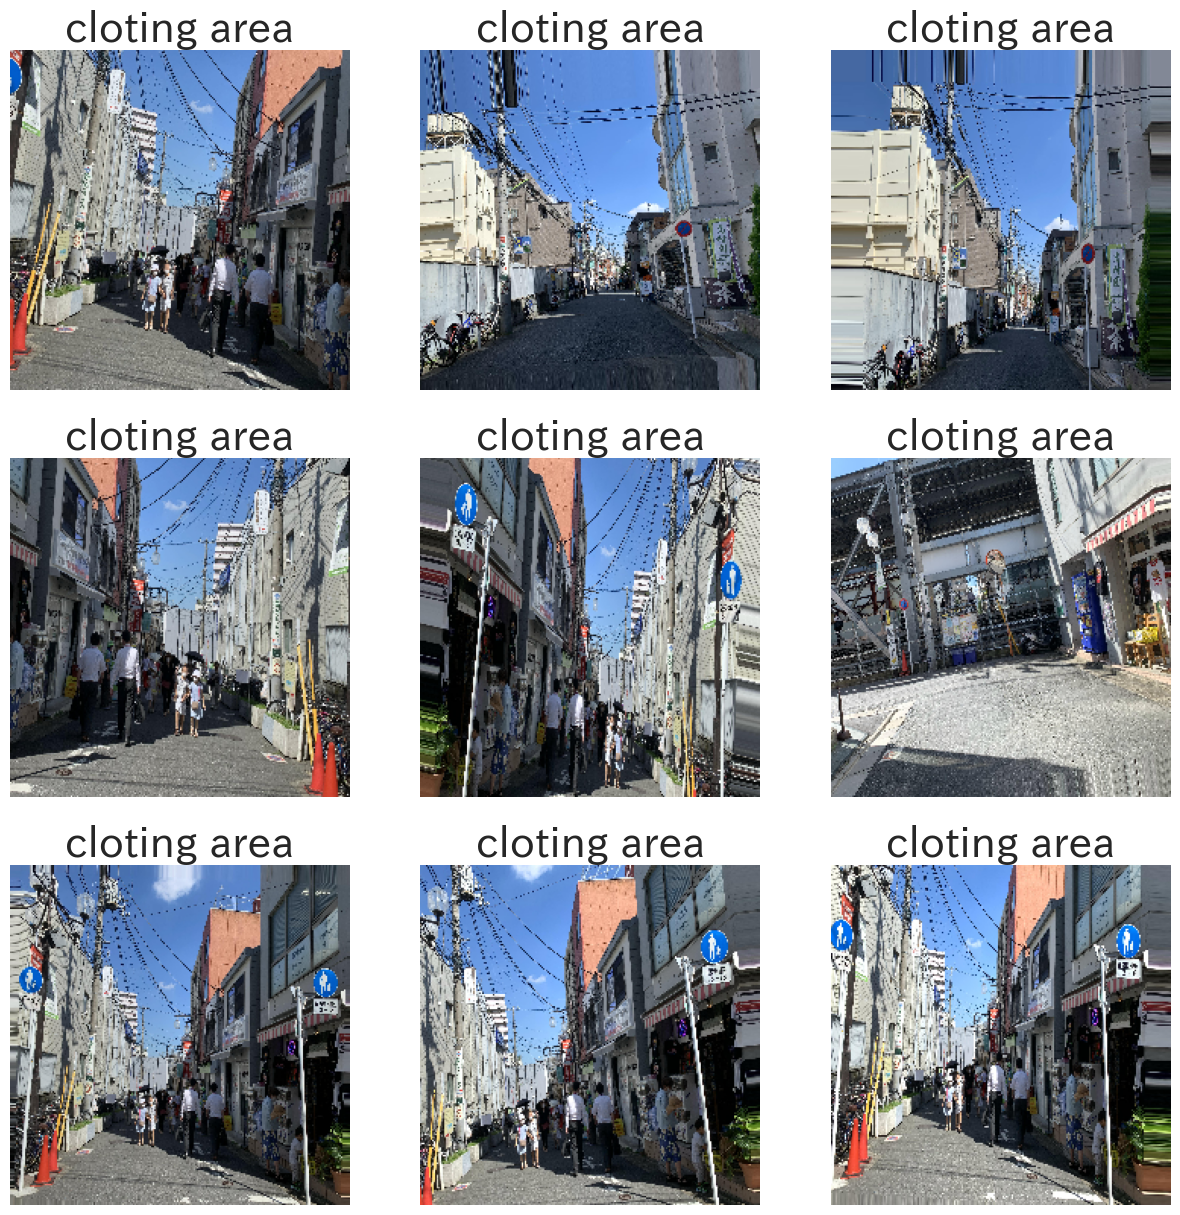

In [ ]:
#ローカルデータセットの画像表示
img_n = 9

idx=0

plt.figure(figsize=(15,15))
for i in range(img_n):
  plt.subplot(3,3,i+1)
  plt.axis('off')

  for j in range(img_n):
    r = random.randint(0,40)
    img = ((x_test2_org[j+r]).astype(np.uint8))
    plt.imshow(img)
    plt.title(y_label_df2[j+r],fontsize=30)
plt.show()

In [ ]:
# 画素値を0から1の範囲に変換（⇒学習の時に計算量を減らす為。結果を出力する時に、再び255掛ける。）
x_test2 = x_test2_org / 255.0

#クラスの形式を変換
#ラベルから多次元のベクトルに（各データごとに正解のラベルが1，不正解が0の1次元のベクトル）
y_test2 = to_categorical(y_test2_org, 4)

# install pre-trained EfficientNet
* 参照：https://logmi.jp/tech/articles/325737

In [ ]:
efficientnet = torchvision.models.efficientnet_b3(pretrained=True)
efficientnet = nn.Sequential(*list(efficientnet.children())[:-2])

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 96.2MB/s]


RuntimeError: ignored

# Define the model

In [ ]:
class FCN(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.FCNhead = nn.Sequential(
            nn.Conv2d(768, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(512, num_classes, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        x = self.backbone(x)
        x = self.FCNhead(x)
        x = F.interpolate(x, size=input_shape, mode="bilinear", align_corners=False)
        return {"out": x}

In [ ]:
# model config
device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = 4
model = FCN(backbone=efficientnet, num_classes=num_classes)

model.to(device)
print(model)

# batch size
batch_size = 16

# optimizerとloss functionとmetricsを定義
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
metrics = MulticlassAccuracy(num_classes=num_classes)

# Transform dataset
* Ref)https://free.kikagaku.ai/tutorial/basic_of_deep_learning/learn/pytorch_basic

* The input data should be in the format (N, C, H, W), where N is the batch size, C is the number of channels, H is the height, and W is the width.

In [ ]:
# transform from numpy to tensor
image_tensors = torch.from_numpy(x_org)
print(image_tensors.shape)
# transform dataset from (N, H, W, C) => (N, C, H, W)
image_tensors = np.transpose(image_tensors , [0,3,1,2])
print("after transfomation:", image_tensors.shape)
label_tensors = torch.from_numpy(y_org)
print(label_tensors.shape)

# summarize x and y into dataset
dataset = torch.utils.data.TensorDataset(image_tensors, label_tensors)

train_dataset, valid_dataset = train_test_split(dataset, test_size=0.2, shuffle=True,random_state=seed)

# splilt by batch size
train_dataloader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True )
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size=batch_size, shuffle=True)

# fine tuning model

In [ ]:
%%time
# 学習の実行
n_epochs = 30



for epoch in range(n_epochs):
    train_losses = []
    valid_losses = []
    metrics.reset()

    model.train()
    with tqdm(total=len(train_dataloader), unit="batch") as pbar:
        pbar.set_description(f"[train] Epoch {epoch+1}/{n_epochs}")
        for image, target in train_dataloader:
            optimizer.zero_grad()

            image, target = image.to(device), target.to(device)
            output = model(image)["out"]
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            pbar.set_postfix(loss=np.array(train_losses).mean())
            pbar.update(1)

    model.eval()
    with torch.no_grad():
        with tqdm(total=len(valid_dataloader), unit="batch") as pbar:
            pbar.set_description(f"[valid] Epoch {epoch+1}/{n_epochs}")
            for image, target in valid_dataloader:
                image, target = image.to(device), target.to(device)
                output = model(image)["out"]
                loss = loss_fn(output, target)
                valid_losses.append(loss.item())
                metrics.update(
                    target.argmax(1).cpu().numpy(), output.argmax(1).cpu().numpy()
                )
                pbar.set_postfix(
                    loss=np.array(valid_losses).mean(), mIoU=metrics.get_scores()
                )
                pbar.update(1)

In [ ]:
def create_CNN_architecture(n_class, input_shape):

    CNN_model = Sequential()

    ############################## 1st layer ##############################
    #convolutional layer
    CNN_model.add(Conv2D(32, input_shape=input_shape, kernel_size=(3,3),padding = 'same',strides=2,name='conv2d',activation='relu'))
    #pooing layer
    CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    ############################## 2nd layer ##############################
    CNN_model.add(Conv2D(64,kernel_size=(3,3),padding = 'same',strides=2,name='conv2d_1',activation='relu'))
    #pooing layer
    CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    ############################## 3rd layer ##############################
    CNN_model.add(Conv2D(128,kernel_size=(3,3),padding = 'same',strides=2,name='conv2d_2',activation='relu'))
    #pooing layer
    CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    ############################## 4th layer ##############################
    CNN_model.add(Conv2D(256,kernel_size=(3,3),padding = 'same',strides=2,name='conv2d_3',activation='relu'))
    # #pooing layer
    # CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # ############################## 5th layer ##############################
    # CNN_model.add(Conv2D(512,kernel_size=(3,3),padding = 'same',strides=2,activation='relu'))

    #Dropout layer
    CNN_model.add(Dropout(0.50))
    # Flatten layer:convert the data to 1-D vector(None, x)
    CNN_model.add(Flatten())
    #fully connected layer(None, x)
    #only accept 1-D vector
    CNN_model.add(Dense(units=512, activation='relu'))
    #Dropout layer
    CNN_model.add(Dropout(0.5))
    #output layer
    CNN_model.add(Dense(n_class, activation='softmax'))

    # print("CNN model summary:", CNN_model.summary())

    return CNN_model

In [ ]:
def create_model_by_learning_data(CNN_model, x_train, y_train, x_val, y_val, epochs, learning_rate):
    #Config of model
    epochs = epochs
    learning_rate = learning_rate

    my_callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
    tsb = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

    CNN_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    r = CNN_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,verbose=1, callbacks=[my_callbacks])
    return r

In [ ]:
def draw_learning_process(r):
    # loss
    hist = r.history
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(1,2,1)
    ax.plot(hist['loss'], label='train_loss',lw=2)
    ax.plot(hist['val_loss'], label='val_loss',lw=2)
    ax.set_title('Training loss', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('loss')

    # accuracy
    ax = fig.add_subplot(1,2,2)
    ax.plot(hist['accuracy'], label='train_accuracy',lw=2)
    ax.plot(hist['val_accuracy'], label='val_accuracy',lw=2)
    ax.set_title('Training accuracy',size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('accuracy')

    plt.legend()
    plt.show()

In [ ]:
def inference_by_CNN(CNN_model, x_test):
    # 予測データごとに正解のラベルを張り付ける
    # argmaxで最大値のインデックスを取り出す
    y_pred =  np.argmax(CNN_model.predict(x_test), axis=-1)

    return y_pred

In [ ]:
def making_confusion_matrix(y_pred, y_label):
    # F-value
    f_score = f1_score(y_label, y_pred, average='micro')
    print('f score:', f_score)

    # kappa
    kappa = cohen_kappa_score(y_label, y_pred, weights='quadratic')
    print('kappa score:', kappa)

    cm = confusion_matrix(y_label, y_pred)
    sns.heatmap(cm, annot=True, fmt='2.0f', cmap='coolwarm')
    plt.title('Confusion matrix', y=1, size=20)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [ ]:
%%time

# config
n_class = 4
n_splits = 3
input_shape = X[0].shape
print('Shape of data:', input_shape)
learning_rate = 0.0001
epochs = 200

kf = StratifiedKFold(n_splits=n_splits, shuffle=True,random_state=seed)

# result of inferences per a CV
predicted_label_gsv_dict = {}
predicted_label_local_dict = {}

#層化K分割交差検証（訓練用と検証用に分ける）
for i, (train_index, val_index) in enumerate(kf.split(X, y_org)):
    i+=1
    print(f"=========================================================================This is {i}times=========================================================================")
    x_train = X[train_index]
    y_train = y_org[train_index]
    x_val = X[val_index]
    y_val = y_org[val_index]

    #ラベルから多次元のベクトルに（各データごとに正解のラベルが1，不正解が0の1次元のベクトル）
    y_train = to_categorical(y_train, 4)
    y_val = to_categorical(y_val, 4)

    #元の学習用データ
    print(X.shape)
    print(Y.shape)
    #訓練データ
    print(x_train.shape)
    print(y_train.shape)
    #検証用データ
    print(x_val.shape)
    print(y_val.shape)
    #テストデータ①
    print(x_test1.shape)
    print(y_test1.shape)
    #テストデータ②
    print(x_test2.shape)
    print(y_test2.shape)

    # learning
    CNN_model = create_CNN_architecture(n_class, input_shape)
    r = create_model_by_learning_data(CNN_model, x_train, y_train, x_val, y_val, epochs=epochs, learning_rate=learning_rate)
    draw_learning_process(r)

    # validate model
    print('========================================= validate =========================================')
    y_val_pred = inference_by_CNN(CNN_model, x_val)
    # confusion matrix
    y_val_true = np.argmax(y_val, axis=-1)
    making_confusion_matrix(y_val_pred, y_val_true)

    # Inference by GSV
    print('========================================= inference GSV =========================================')
    y_test_pred_gsv = inference_by_CNN(CNN_model, x_test1)
    # confusion matrix
    y_test_true_gsv = np.argmax(y_test1, axis=-1)
    making_confusion_matrix(y_test_pred_gsv, y_test_true_gsv)

    # Inference by local
    print('========================================= inference local =========================================')
    y_test_pred_local = inference_by_CNN(CNN_model, x_test2)
    # confusion matrix
    y_test_true_local = np.argmax(y_test2, axis=-1)
    making_confusion_matrix(y_test_pred_local, y_test_true_local)

    predicted_label_gsv_dict[i] = (y_test_true_gsv)
    predicted_label_local_dict[i] = (y_test_pred_local)

In [ ]:
# calculate the average of GCV test dataset
length = len(predicted_label_gsv_dict[1])

label_list = []

# decide the label by all of result per CV
for i in range(length):
  label = np.argmax(np.bincount([predicted_label_gsv_dict[1][i], predicted_label_gsv_dict[2][i], predicted_label_gsv_dict[3][i]]))
  label_list.append(label)
print(label_list)
making_confusion_matrix(label_list, y_test_true_gsv)

In [ ]:
# calculate the average of local test dataset
length = len(predicted_label_local_dict[1])

label_list = []

# decide the label by all of result per CV
for i in range(length):
  label = np.argmax(np.bincount([predicted_label_local_dict[1][i], predicted_label_local_dict[2][i], predicted_label_local_dict[3][i]]))
  label_list.append(label)
print(label_list)
making_confusion_matrix(label_list, y_test_true_local)

## 精度向上ポイント
* adam→AMSGrad
* model : CNN⇒transormer

# Visualized by Grad-CAM

In [ ]:
#Grad-CAM
def grad_cam(input_model, x, layer_name):
    """
    Args:
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない(通常の学習では、1200枚などの)
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32') / 255.0

    #最終conv層のアウトプットとモデルのアウトプットを出力するモデルを作成
    grad_model = Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    #forward passにて最終conv層の出力が0以上のみを残す
    gate_f = tf.cast(output > 0, 'float32')
    #backwardにて勾配が0以上のみを残す
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    IMAGE_SIZE=(300,300)
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    output_image = (np.float32(rgb_cam) + x / 2)

    return output_image

In [ ]:
[print('input shape:',i.shape, i.dtype) for i in CNN_model.inputs]
[print('output shape:',o.shape, o.dtype) for o in CNN_model.outputs]
[print('layer name:',l.name, l.input_shape, l.dtype) for l in CNN_model.layers]

## GSV test dataset

In [ ]:
#CNNが正解した検証用データに対してGrad-CAMを実行（縦）
plt.figure(figsize=(20,20))

length_gsv_test = len(x_test1)
for i in range(0, length_gsv_test):
    plt.subplots()
    plt.axis('off')

    # using CNN model created at last CV
    cam = grad_cam(CNN_model, (x_test1[i]*255).astype(np.uint8), "conv2d_3")
    img = array_to_img(cam)
    plt.imshow(img)
    plt.title("True label: %s" % (y_test_true_gsv[i]),fontsize=30)
plt.show()

## local test dataset

In [ ]:
#CNNが正解した検証用データに対してGrad-CAMを実行（縦）
plt.figure(figsize=(20,20))

length_local_test = len(x_test2)
for i in range(0, length_local_test):
    plt.subplots()
    plt.axis('off')

    # using CNN model created at last CV
    cam = grad_cam(CNN_model, (x_test2[i]*255).astype(np.uint8), "conv2d_3")
    img = array_to_img(cam)
    plt.imshow(img)
    plt.title("True label: %s" % (y_test_true_local[i]), fontsize=30)
plt.show()